# Tempo Estimation for Music Loops and a Simple Confidence Measure


This notebook contains code and instructions for reproducing part of the research described in the 
paper *Font, F., & Serra, X. (2016). Tempo Estimation for Music Loops and a Simple Confidence 
Measure. In Int. Conf. on Music Information Retrieval (ISMIR)*. The full text of the 
paper can be [found here](http://mtg.upf.edu/node/3479) and the original Github repo [here](https://github.com/ffont/ismir2016).

## Datasets

In this notebook we will analyse three datasets:

 * **FSL4**: This dataset contains user-crontributed loops uploaded to [Freesound](http://www.freesoud.org). It has been built in-house by searching Freesound for sounds with the query terms *loop* and *bpm*, and then automatically parsing the returned sound filenames, tags and textual descriptions to identify tempo annotations made by users. For example, a sound containing the tag *120bpm* is considered to have a ground truth of 120 BPM. 
 * **APPL**: This dataset is composed of the audio loops bundled in [Apple's Logic Pro](http://apple.com/logic-pro/) music production software. We parsed the metadata embedded in the audio files using source code available in a [public repository](http://github.com/jhorology/apple-loops-meta-reader), and extracted in this way tempo annotations for all the loops.
 * **MIXL**: This dataset contains all the loops bundled with Acoustica's [Mixcraft 7 music production software](http://acoustica.com/mixcraft/). Tempo annotations are provided in its loop browser and can be easily exported into a machine-readable format.
 
 The three datasets have already beem downloaded and setup on the Google Drive folder, and all the audio files are located at `data\datasetname\audio\wav\`.


First, we mount the Google Drive so as to be able to access the files

In [0]:
from google.colab import drive
#force_remount forces a remount whenever this cell is ran for the second time
drive.mount('/content/gdrive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Setting up the analysis algorithms

According to Bock15, most tempo estimation algorithms follow a similar procedure: 

* Transform the audio signal into a down-sampled feature;
* Estimate the periodicities;
* Select one of the periodicities as tempo.

Reduction functions used were:

*   The signal's envelope;
*   Band pass filter;
*   Onset detection functions.

Periodicity estimation algorithms used were:

* Fast FourierTransform (FFT) based methods like tempograms;
* Autocorrelation;
* Comb filters.

Finally, to select the most proeminent periodicity, several methods were used:

* Selecting the highest periodicity peak 
* Hidden Markov models (HMM)
* Gaussian mixture model (GMM) regression
* Support vector machines (SVM)


For analysing how existing algorithms perform when classifying loops, we take 

#### Percival14

This algorithm is described in *Graham Percival and George Tzanetakis. Streamlined tempo estimation based on autocorrelation and cross-correlation with pulses. IEEE/ACM Transac- tions on Audio, Speech, and Language Processing, 22(12):1765–1776, 2014*.

In the Google Drive, we include an up to date Python version of the code which was originally provided by the authors and can be found [http://opihi.cs.uvic.ca/tempo/](http://opihi.cs.uvic.ca/tempo/). Code from the authors can also be found in the [Marsyas](http://marsyas.info) audio analysis library [code repository](https://github.com/marsyas/marsyas/tree/master/scripts/large-evaluators/tempo-reference-implementation). 

Two implementations are available on the Google Drive in the `algorithms` folder. These are Percival14 (original implementation) and Percival14Mod. `Compare Percival14 variations.ipynb` notebook describes the difference between these two implementations, as well as the version implemented in Essentia, and compares their performance. If you would like to modify this algorithm, you should take a look at this notebook.


#### Degara12 and Zapata14

These algorithms are described in *Norberto Degara, Enrique Argones Rua, Antonio Pena, Soledad Torres-Guijarro, Matthew EP Davies, and Mark D Plumbley. Reliability-Informed Beat Tracking of Musical Signals. IEEE Transactions on Audio, Speech, and Language Processing, 20(1):290– 301, 2012*, and 
*Jose R Zapata, Matthew EP Davies, and Emilia Gómez. Multi-Feature Beat Tracking. IEEE/ACM Transactions on Audio, Speech, and Language Pro- cessing, 22(4):816–825, 2014*, respectively.

In our evaluation we use the implementation of both algorithms provided in the open-source [Essentia audio analysis library](http://essentia.upf.edu). To set it up you'll need to install Essentia (see [installation instructions](http://essentia.upf.edu/documentation/installing.html) including its python bindings.
Once this is done the algorithms will be properly set up.

Essentia is devloped by the [Music Technology Group of Universitat Pompeu Fabra](http://mtg.upf.edu).
In our paper we used Essentia version ```2.1 beta2```.


#### Böck15

This algorithm is described in *Böck Sebastian, Florian Krebs, and Gerhard Widmer. Accurate Tempo Estimation based on Recurrent Neural Networks and Resonating Comb Filters. In Proc. of the Int. Conf. on Music Information Retrieval (ISMIR), 2015*.

An implementation of this alorithm provided by the original authors can be found in the oepn source audio analysis Python package [Madmom](https://madmom.readthedocs.io/en/latest/). The source code can be found in this [source code repository](https://github.com/CPJKU/madmom). 

Madmom is devloped by the [Department of Computational Perception of Johannes Kepler Universität](http://www.cp.jku.at).
In this notebook we use Madmom version ```0.16```.



### Install the required libraries

Most of the libraries required are already available on the Google Collab virtual environment. The rest of the libraries can be installed just by running the following `pip install`commands.

In [0]:
!pip install madmom
!pip install vlc
!pip install essentia
!pip install Celery

## Analyzing the datasets

Before running the experiments of the paper, all the datasets must be analysed with the selected
algorithms. These algorithms include the tempo estimation algorithms that are compared in the paper and some extra algorithms which are useful to quickly compute the confidence measure. 

Every folder in the `Data` directory is treated as a dataset. The datasets are already analyzed, but, in case some other algorithm is added or an existing algorithm is modified, the analysis has to be rerun. 


To analyse the datasets we use the script `analyze_dataset.py` found in the `scripts` folder. 

*Note:* check the [source code of the script](https://github.com/ffont/ismir2016/blob/master/scripts/analyze_dataset.py) for extra running options (including the [use of celery to speed-up computation time](#celery)).



In [0]:
%cd '/content/gdrive/My Drive/Loop Tempo Extraction/'
!jupyter trust Main.ipynb

#!python scripts/analyze_dataset.py data/FSL4/
#!python scripts/analyze_dataset.py data/Appleloops/
#!python scripts/analyze_dataset.py data/Mixcraft/


/content/gdrive/My Drive/Loop Tempo Extraction
[TrustNotebookApp] Writing notebook-signing key to /root/.local/share/jupyter/notebook_secret
Signing notebook: Main.ipynb


After running the script, a number of `JSON` files are generated inside the dataset folder with the results of the different analyses:

```
dataset_name/
    dataset_info.json
    metadata.json
    audio/wav/
    analysis_durations.json  <- results of the estimated duration of the files
    analysis_rhythm_essentia_basic.json  <- results of Zapata14 and Degara12 methods (from Essentia)
    analysis_rhythm_madmom.json  <- results of Bock15
    analysis_rhythm_percival14.json  <- results of Percival14
```

## Data Analysis

In this section, we'll start by processing analysing the datasets, so as to better understand their characteristics.

In [0]:
from shared_notebook_utils import *
from scipy.stats import gaussian_kde
from collections import Counter
# Add the datasets you want to analyze in 'dataset_dirnames'
# Change the directory names listed here by the ones set in your data folder.
# In this repository we include an example 'toy_dataset' that can be used to test the notebook.
dataset_dirnames = ['FSL4', 'Appleloops', 'Mixcraft'] 
datasets = load_datasets(dirnames=dataset_dirnames, clean=True)
%matplotlib inline

### Cleanning datasets

Because of the nature of how the datasets were collected, we found that some of the loops do not have a BPM annotations that we can use as ground truth or have a BPM annotation which is outside what could be intuitively considered a reasonable tempo range. To avoid inconsistencies with the annotations, we clean the datasets by removing instances with no BPM annotation or with a BPM annotation outside a range of $[25, 300]$. 
Interestingly, we see that all the loops in our datasets are annotated with integer tempo values, meaning that it is not common for music loops to be produced with tempo values with less than 1 BPM resolution.

In [0]:
for count, dataset in enumerate(datasets):
    print ('Cleaning %s' % dataset.short_name)
    aceptable_instances = dataset.filter_data(condition=condition_instance_acceptable)
    n_instances_removed = len(dataset.data) - len(aceptable_instances.data)
    datasets[count] = aceptable_instances
    print ('done! (%i instances removed, %.2f%%)' % (n_instances_removed, 100.0 * n_instances_removed / len(dataset.data)))
    
print (title('Function used to filter each instance:'))
print (inspect.getsource(condition_instance_acceptable))

Cleaning FSL4
done! (0 instances removed, 0.00%)
Cleaning Appleloops
done! (0 instances removed, 0.00%)
Cleaning Mixcraft
done! (0 instances removed, 0.00%)

Function used to filter each instance:
--------------------------------------

def condition_instance_acceptable(key, item, data):
    annotated_bpm = vfkp(item, 'annotations.bpm')
    if annotated_bpm == 0 or annotated_bpm is None:
        return False
    if annotated_bpm < 30 or annotated_bpm > 300:
        return False
    return True



### Basic dataset statistics

In this section, we calculate the number of loops, their total and mean duration, the range of durations for each dataset and the anotation tempo range.

In [0]:
table_header = ['Dataset', 'N', 'T. Duration', 'Mean Duration', 'Durations range', 'Tempo range']
table_rows = list()
genres = dict()

for dataset in datasets:
    row = [dataset.short_name]
    row.append(len(dataset.data))
    durations = dataset.get_data('analysis.durations.duration')
    durations = np.array(durations)
    row.append('%ih %im' % (int(durations.sum()) / 3600, int(durations.sum() % 3600) / 60))
    row.append('%.2fs' % durations.mean())
    row.append('%.2fs - %.2fs' % (durations.min(), durations.max()))
    tempos = dataset.get_data('annotations.bpm')
    row.append('%i - %i' % (min(tempos), max(tempos)))    
    table_rows.append(row)

print (title('Basic statistics per dataset'))
print_table(table_header, table_rows, highlight_max=False)


Basic statistics per dataset
----------------------------

Dataset      N      T. Duration   Mean Duration   Durations range   Tempo range   
----------------------------------------------------------------------------------
FSL4         3949   8h 22m        7.63s           0.15s - 30.00s    32 - 300      
Appleloops   4611   9h 34m        7.47s           1.32s - 40.05s    53 - 140      
Mixcraft     5451   14h 11m       9.37s           0.32s - 110.77s   55 - 220      


### Extra plots

The code below generates some extra plots (not found in the paper) which show relevant information about the datasets.

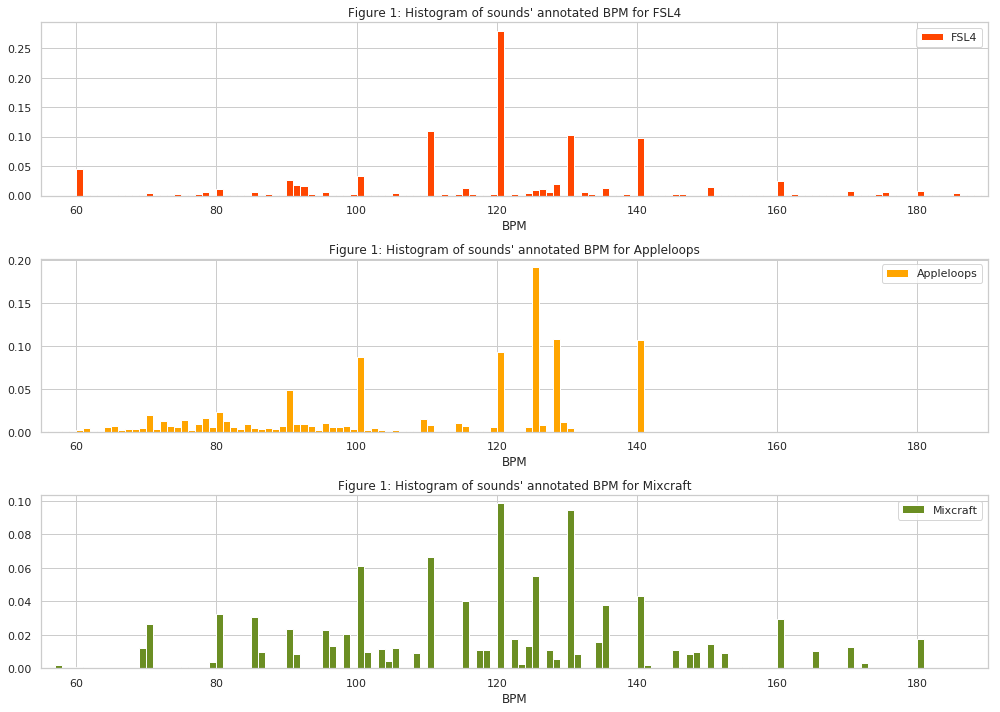

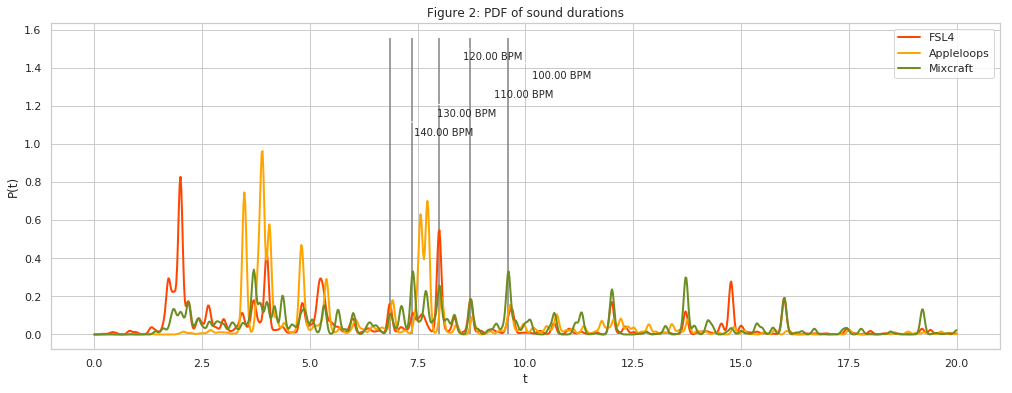

In [38]:
# BPM histograms for each dataset
n_datasets = len(datasets)
if not n_datasets:
    raise Exception("No datasets were specified or could be loaded!")
nrows = n_datasets
ncols = 1
fig1, axs = plt.subplots(nrows, ncols, figsize=(14, 10))

for count, dataset in enumerate(datasets):
    tempos = dataset.get_data('annotations.bpm')
    min_tempo = 30
    max_tempo = 300
    
    if n_datasets == 1:
        ax = axs
    else:
        ax = axs[count]
    
    ax.hist(tempos, bins=max_tempo-min_tempo, range=(min_tempo,max_tempo), density=True, label=dataset.short_name, color=COLORS[count])
    ax.set_xlabel('BPM')
    ax.set_xlim((55, 190))
    ax.legend()
    ax.set_title('Figure 1: Histogram of sounds\' annotated BPM for %s' % dataset.short_name)

plt.tight_layout()
plt.show()


# Probability density function of sounds' duration
fig2, ax2 = plt.subplots(1, 1, figsize=(17, 6))
for count, dataset in enumerate(datasets):
    sound_durations = dataset.get_data('analysis.durations.duration')
    sound_durations = np.array(sound_durations)
    kde = gaussian_kde(sound_durations, bw_method=0.05 / sound_durations.std(ddof=1))
    x_grid = np.linspace(0.0, 20.0, 1000)
    x = kde.evaluate(x_grid)
    ax2.plot(x_grid, x, color=COLORS[count], linewidth=2.0, label=dataset.short_name)
    x_peaks = detect_n_max_peaks(x, n=8)
    
ax2.set_title('Figure 2: PDF of sound durations')
ax2.set_xlabel('t')
ax2.set_ylabel('P(t)')
ax2.legend()
for count, peak_position in enumerate([8.0, 9.6, 8.72, 7.38, 6.86]):
    estimate_bpm = int(round(60.0/peak_position * 16))
    if 60 <= estimate_bpm <= 200:
        ax2.vlines(peak_position, 0, 1.56, label='tick', color='gray')
        label = '%.2f BPM' % estimate_bpm
        ax2.annotate(label, xy=(peak_position + 0.1, 1.55 - count * 0.1), xycoords='data',
                     xytext=(20, -20), textcoords='offset points',
                     arrowprops=dict(arrowstyle="->"))
plt.show()

## Confidence measure


Assuming that we obtain a BPM estimate for a given audio signal, the confidence measure that we propose is based on comparing the duration of the whole audio signal with a multiple of the duration of a single beat according to the estimated BPM. If the actual duration of the signal is close to a multiple of the duration of a single beat, we hypothesise that the BPM estimation is reliable.
We consider the best BPM estimate of a tempo estimation algorithm to be its nearest integer value (see paper for more details).
Given the sample rate $SR$ of an audio signal and its estimated tempo $BPM^e$, we can estimate the duration (or length) of an individual beat in number of samples $l^b$ as
$$l^b = \frac{60 \cdot SR}{BPM^e}.$$ 

Then, potential durations for the audio signal can be computed as multiples of the individual beat duration, $L[n] = n \cdot l^b$, where $n \geq 1, n \in \mathbb{Z}$.
In our computation, we restrict $n$ to the range $1 \le n \le 128$.
This is decided so that the range can include loops that last from only 1 beat to 128 beats, which would correspond to a maximum of 32 bars in 4/4 meter. 
In practice, what we need here is a number big enough such that we wont find loops longer than it.
Given $L$, what we need to see at this point is if any of its elements closely matches the actual length of the original audio signal. 
To do that, we take the actual length of the audio signal $l^a$ (in number of samples), compare it with all elements of $L$ and keep the minimum difference found:

$$ \Delta l = \min\{|L[n]-l^a|:n\le 128\}. $$

A value of $\Delta l$ near 0 means that there is a close match between one of the potential lengths and the actual length of the audio signal. 
Having computed $\Delta l$, we finally define our confidence measure as 

$$ 
confidence = \begin{cases} 
	0 & \text{if } \Delta l > \lambda \\
    1 - \frac{\Delta l}{\lambda} & \text{otherwise}\\
\end{cases},
$$

where $\lambda$ is a parameter set to half the duration of a single beat ($\lambda = 0.5 \cdot l^b$). In this way, if $l^a$ exactly matches one of the multiples of $l^b$, the confidence will be 1. If $\Delta l$ is as long as half the duration between beats, the confidence will be 0 (see top of the figure below).

The reasoning behind this simple confidence measure is that it is very unlikely that, only by chance, an audio signal has a duration which closely matches a multiple of the beat duration for a given estimated BPM. This means that we assume that there is a relation between the duration of the signal and its BPM, and therefore our proposed confidence will fail if the audio signal contains silence (either at the beginning or at the end) which is not part of the loop itself (i.e.,~ the loop is not *accurately cut*).
To account for this potential problem, we estimate the duration that the audio signal would have if we removed silence at the beginning, at the end, or both at the beginning and at the end.
We take the envelope of the original audio and consider the effective starting point of the loop as being the point in time $t_s$ where the envelope amplitude raises above 5\% of the maximum.
Similarly, we consider the effective end $t_e$ at the *last point* where the envelope goes below the 5\% of the maximum amplitude (or at the end of the audio signal if envelope is still above 5\%). 
Taking $t_s$, $t_e$, and $l^a$ (the original signal length), we can then compute three alternative estimates for the duration of the loop ($l_0^{a}$, $l_1^{a}$ and $l_2^{a}$) by *i)* disregarding silence at the beginning ($l_0^{a} = l^a - t_s$), *ii)* disregarding silence a the end ($l_1^{a} = t_e$), and *iii)* disregarding silence both at the beginning and at the end ($l_2^{a} = t_e - t_s$).
Then, we repeat the previously described confidence computation with the three extra duration estimates $l_0^{a}$, $l_1^{a}$ and $l_2^{a}$. 
Note that these will produce meaningful results in cases where the original loop contains silence which is not relevant from a musical point of view, but they will not result in meaningful confidence values if the loop contains silence at the beginning or at the end which is in fact part of the loop (i.e.,~which is needed for it seamless repetition).
Our final confidence value is taken as the maximum confidence obtained when using any of $l^{a}$, $l_0^{a}$, $l_1^{a}$ and $l_2^{a}$ estimated signal durations (see bottom of figure below).

Because the confidence measure that we propose only relies on a BPM estimate and the duration of the audio signal, it can be used in combination with any existing tempo estimation algorithm. Also, it is computationally cheap to compute as the most complex operation it requires is the envelope computation. However, this confidence measure should not be applied to content other than music loops as it only produces meaningful results under the assumption that tempo is completely steady across the whole signal.




In [0]:
from shared_notebook_utils import *
from analysis_algorithms import *
import essentia
import essentia.standard as estd
import random
#You can change the dataset name to analyze a different one
dataset = Dataset('FSL4')
%matplotlib inline


Selected sound id: 63470
------------------------



Selected sound ground truth bpm: 140.00
Selected sound estimated bpm: 119.00
  Confidence: 0.59

Selected sound id: 43209
------------------------



Selected sound ground truth bpm: 91.00
Selected sound estimated bpm: 91.00
  Confidence for "Standard duration": 0.40
  Confidence for "Removed silence beginning": 0.70
  Confidence for "Removed silence end": 0.66
  Confidence for "Removed slience beginning and end": 0.97


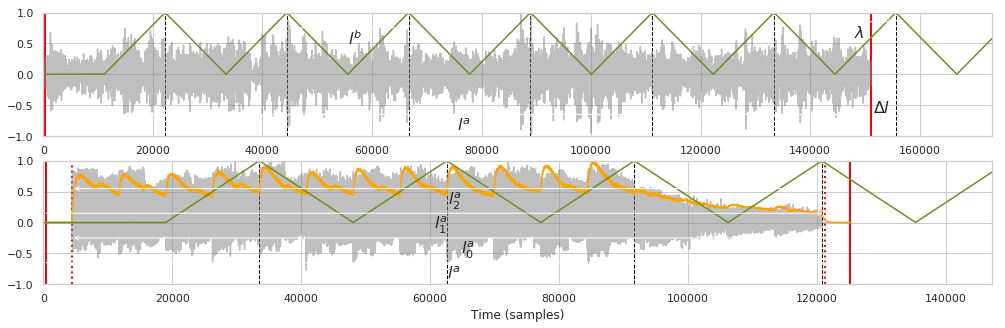


**Figure 1**: Visualisation of confidence computation output according to BPM estimation and signal duration (green curves). The top figure shows a loop whose annotated tempo is 140 BPM but the predicted tempo is 119 BPM.
The duration of the signal $l^a$ does not closely match any multiple of $l^b$ (dashed vertical lines), and the output confidence is 0.59 (i.e.,~$1 - \Delta l / \lambda$).
The figure at the bottom shows a loop that contains silence at the beginning and at the end, and for which tempo has been correctly estimated as being 91 BPM.
The yellow curve represents its envelope and the vertical dashed red lines the estimated effective start and end points.
Note that $l_2^a$ closely matches a multiple of $l^b$, resulting in a confidence of 0.97. The output confidence computed with $l^{a}$, $l_0^{a}$ and $l_1^{a}$ produces lower values.

In [0]:
# The following code exemplifies the computation of the confidence measure for two different sound examples 
# and generates Figure 1 of the paper.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17, 5))
sample_rate=44100


# Top of the figure: loop for which BPM estimation fails
########################################################

# Select and load a sound
# Sound: "edison_140d.wav" by NoiseCollector, got from Freesound at http://www.freesound.org/people/NoiseCollector/sounds/63470/
# License: CC-BY-3.0
selected_sound = dataset.data['63470']
print (title('Selected sound id: %s' % selected_sound['id']))
sound_file_path = os.path.join(dataset.dataset_path, selected_sound['wav_sound_path'])
selected_sound['file_path'] = sound_file_path
audio_1 = load_audio_file(file_path=sound_file_path, sample_rate=sample_rate)
bpm_1 = algorithm_rhythm_percival14(selected_sound)['Percival14']['bpm']
bpm_1 = int(round(bpm_1))
IPython.display.display(IPython.display.Audio(sound_file_path))
print ('Selected sound ground truth bpm: %.2f' % selected_sound['annotations']['bpm'])
print ('Selected sound estimated bpm: %.2f' % bpm_1)

# Compute confidence based on "standard" audio signal duration
beat_duration = (60.0 * sample_rate)/bpm_1
L = [beat_duration * n for n in range(1, 128)]
thr_lambda = 0.5 * beat_duration
la = audio_1.shape[0]
delta_l = min([abs(l - la) for l in L])
if delta_l > thr_lambda:
    confidence_la = 0.0
else:
    confidence_la = (1.0 - float(delta_l) / thr_lambda)
print ('  Confidence: %.2f' % confidence_la)

# Plot
ax1.plot(normalize2(audio_1), color="gray", alpha=0.5)
ax1.vlines(L, -1, 1, color='black', linewidth=1, linestyle="--")
ax1.vlines([350, la], -1, 1, color='red', linewidth=2)
annotate_point_pair(ax1, r'$l^a$', (0, -0.65), (la, -0.65), xycoords='data', text_offset=16, text_size=16)
annotate_point_pair(ax1, r'$l^b$', (L[1], 0.75), (L[2], 0.75), xycoords='data', text_offset=16, text_size=16)
annotate_point_pair(ax1, r'$\Delta l$', (la, -0.35), (la + delta_l, -0.35), xycoords='data', text_offset=16, textx_offset=-2000, text_size=16)
annotate_point_pair(ax1, r'$\lambda$', (la + delta_l - thr_lambda, 0.85), (la + delta_l, 0.85), xycoords='data', text_offset=16, textx_offset=-2000, text_size=16)
confidence_output = list()
for i in range(0, la*2):
    delta = min([abs(l - i) for l in L])
    if delta > thr_lambda:
        confidence_output.append(0.0)
    else:
        value = 1.0 - float(delta) / thr_lambda
        confidence_output.append(value)
ax1.plot(confidence_output, color=COLORS[2])
ax1.set_xlim((0, la + 44100/2))
ax1.set_ylim((-1, 1))
#ax1.set_xlabel('Time (samples)')


# Bottom of the figure: loop for which BPM estimation works but that has silence at the beggining
#################################################################################################

# Select and load sound and add 100 ms silence at the beginning and at the end
# Sound: "91Apat99999.wav" by NoiseCollector, got from Freesound at http://www.freesound.org/people/NoiseCollector/sounds/43209/
# License: CC-BY-3.0
selected_sound = dataset.data['43209']
print (title('Selected sound id: %s' % selected_sound['id']))
sound_file_path = os.path.join(dataset.dataset_path, selected_sound['wav_sound_path'])
selected_sound['file_path'] = sound_file_path
audio_1 = load_audio_file(file_path=sound_file_path, sample_rate=sample_rate)
n_samples_silence = 4410
audio_2 = np.concatenate((np.zeros(n_samples_silence), audio_1, np.zeros(n_samples_silence)))
bpm_2 = algorithm_rhythm_percival14(selected_sound)['Percival14']['bpm']
bpm_2 = int(round(bpm_2))
IPython.display.display(IPython.display.Audio(sound_file_path))
print ('Selected sound ground truth bpm: %.2f' % selected_sound['annotations']['bpm'])
print ('Selected sound estimated bpm: %.2f' % bpm_2)

# Compute confidence based on different durations
beat_duration = (60.0 * sample_rate)/bpm_2
L = [beat_duration * n for n in range(1, 128)]  # From 1 beat to 32 beats (would be 32 bars in 4/4)
thr_lambda = 0.5 * beat_duration
z = 0.05  # Percentage of the envelope amplitude that we use to compute start and end of signal
env = estd.Envelope(attackTime=10, releaseTime=10)
envelope = env(essentia.array(audio_2))
env_threshold = envelope.max() * z
envelope_above_threshold = np.where(envelope >= env_threshold)
start_effective_duration = envelope_above_threshold[0][0]
end_effective_duration = envelope_above_threshold[0][-1]
la = audio_2.shape[0]
durations_to_check = [
    ('Standard duration', la),
    ('Removed silence beginning', la - start_effective_duration),
    ('Removed silence end', end_effective_duration),
    ('Removed slience beginning and end', end_effective_duration - start_effective_duration)
]
for name, duration in durations_to_check:
    delta_l = min([abs(l - duration) for l in L])
    if delta_l > thr_lambda:
        confidence = 0.0
    else:
        confidence = (1.0 - float(delta_l) / thr_lambda)
    print ('  Confidence for "%s": %.2f' % (name, confidence))

# Plot
ax2.plot(normalize2(audio_2), color="gray", alpha=0.5)
ax2.plot(normalize2(envelope), color=COLORS[1])
ax2.vlines([l + start_effective_duration for l in L], -1, 1, color='black', linewidth=1, linestyle="--")
ax2.vlines([start_effective_duration, end_effective_duration], -1, 1, color='red', linewidth=2, linestyle=":")
ax2.vlines([350, la], -1, 1, color='red', linewidth=2)
annotate_point_pair(ax2, r'$l^a$', (0, -0.65), (la, -0.65), xycoords='data', text_offset=16, text_size=16)
annotate_point_pair(ax2, r'$l_0^a$', (start_effective_duration, -0.25), (la, -0.25), xycoords='data', text_offset=16, text_size=16)
annotate_point_pair(ax2, r'$l_1^a$', (0, 0.15), (end_effective_duration, 0.15), xycoords='data', text_offset=16, text_size=16)
annotate_point_pair(ax2, r'$l_2^a$', (start_effective_duration, 0.55), (end_effective_duration, 0.55), xycoords='data', text_offset=16, text_size=16)
confidence_output = list()
for i in range(0, la*2):
    delta = min([abs(l - i) for l in L])
    if delta > thr_lambda:
        confidence_output.append(0.0)
    else:
        value = 1.0 - float(delta) / thr_lambda
        confidence_output.append(value)
confidence_output = list(np.zeros(start_effective_duration)) + confidence_output
ax2.plot(confidence_output, color=COLORS[2])
ax2.set_xlim((0, la + 44100/2))
ax2.set_ylim((-1, 1))
ax2.set_xlabel('Time (samples)')

plt.show()
figure_caption = """
**Figure 1**: Visualisation of confidence computation output according to BPM estimation and signal duration (green curves). The top figure shows a loop whose annotated tempo is 140 BPM but the predicted tempo is 119 BPM.
The duration of the signal $l^a$ does not closely match any multiple of $l^b$ (dashed vertical lines), and the output confidence is 0.59 (i.e.,~$1 - \Delta l / \lambda$).
The figure at the bottom shows a loop that contains silence at the beginning and at the end, and for which tempo has been correctly estimated as being 91 BPM.
The yellow curve represents its envelope and the vertical dashed red lines the estimated effective start and end points.
Note that $l_2^a$ closely matches a multiple of $l^b$, resulting in a confidence of 0.97. The output confidence computed with $l^{a}$, $l_0^{a}$ and $l_1^{a}$ produces lower values."""
IPython.display.display(IPython.display.Markdown(figure_caption))

## Overall tempo estimation accuracy

Similarly to previous tempo estimation works, we follow the methodology described by Gouyon et al. [1] to test the aforementioned algorithms against the four collected datasets. 
In addition the standard *Accuracy 1* and *Accuracy 2* measures (with 4% tolerance), we add an extra measure that we call *Accuracy 1e* and that represents the percentage of instances whose estimated BPM is exactly the same as the ground truth after rounding the estimated BPM to the nearest integer. Accuracy 1e is therefore more strict than Accuracy 1.
The reason why we added this extra accuracy measure is that, imagining a music creation context where loops can be queried in a database, it is of special relevance to get returned instances whose BPM exactly matches that specified as target.

The overall accuracy results show that Percival14 obtains the highest accuracy scores for all accuracy measures and all datasets except for the LOOP dataset, in which highest score for Accuracy 1 is obtained by Zapata14 (see Figure 1 in the cell below). Considering the data from all datasets at once, mean accuracy values for Percival14 range from 47% (Accuracy 1e) to 73% (Accuracy 2), with an average increase of 7% accuracy when compared with the second best-scored method. With a few exceptions, pairwise accuracy differences between Percival14 and the second best-scored method in all datasets and accuracy measures are statistically significant using McNemar's test and a significance value of $\alpha=0.01$ (i.e.,~$p \ll 0.01$). 
We also observe that accuracies for the APPL dataset tend to be higher than for other datasets. This can be explained by the fact that APPL contains professionally created and curated loops, while the other datasets contain user contributed content, not necessarily created by professionals (Mixcraft's loop library also contains content gathered from online repositories).

[1] Fabien Gouyon, Anssi Klapuri, Simon Dixon, Miguel Alonso, George Tzanetakis, Christian Uhle, and Pedro Cano. An Experimental Comparison ofAudio Tempo Induction Algorithms. IEEE Transactions on Audio, Speech and Language Processing, 14(5):1832–1844, 2006.


In [0]:
from shared_notebook_utils import *
from statsmodels.sandbox.stats.runs import mcnemar
# Add the datasets you want to analyze in 'dataset_dirnames'
# Change the directory names listed here by the ones set in your data folder.
# In this repository we include an example 'toy_dataset' that can be used to test the notebook.
dataset_dirnames = ['FSL4', 'Appleloops', 'Mixcraft'] 
datasets = load_datasets(dirnames=dataset_dirnames, clean=True)  # Load and clean datasets
# Add the datasets you want to analyze in 'methods_to_compare'
methods_to_compare = ['Percival14', 'Zapata14', 'Degara12', 'Bock15']
%matplotlib inline



General tempo estimation results (FSL4)
****************************************


Method       Accuracy 1e   Accuracy 1   Accuracy 2   
-----------------------------------------------------
Percival14   43.86         54.42        70.37        
Bock15       21.22         34.49        64.17        
Zapata14     28.69         52.65        60.60        
Degara12     30.34         53.00        60.60        


General tempo estimation results (Appleloops)
**********************************************


Method       Accuracy 1e   Accuracy 1   Accuracy 2   
-----------------------------------------------------
Percival14   55.97         69.51        79.66        
Degara12     31.27         66.69        78.18        
Zapata14     31.73         66.69        77.42        
Bock15       33.40         42.64        69.20        


General tempo estimation results (Mixcraft)
********************************************


Method       Accuracy 1e   Accuracy 1   Accuracy 2   
-----------------------

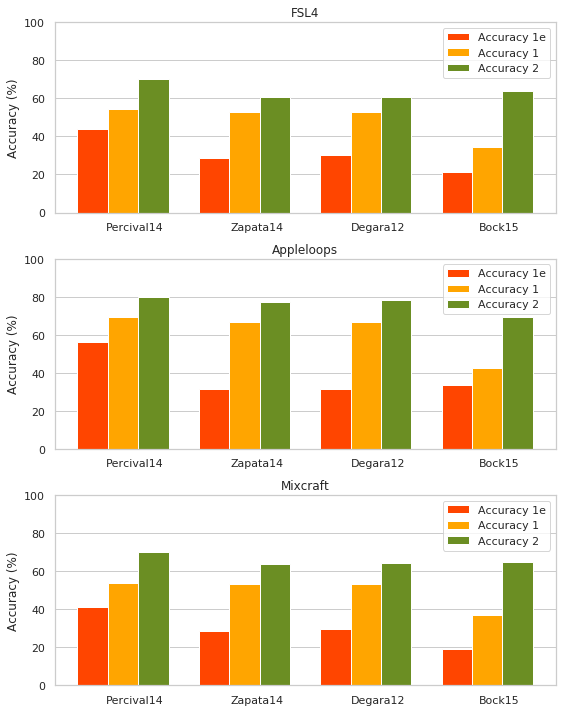


**Figure 1**: Overall tempo estimation accuracies.



General tempo estimation results (ALL DATASETS)
-----------------------------------------------

Method       Accuracy 1e   Accuracy 1   Accuracy 2   Mean accuracy   
---------------------------------------------------------------------
Percival14   46.86         59.05        73.35        59.75           
Degara12     30.46         57.58        67.77        51.94           
Zapata14     29.70         57.46        67.39        51.52           
Bock15       24.34         38.22        66.00        42.85           


In [39]:
# Prepare figure
n_datasets = len(datasets)
if not n_datasets:
    raise Exception("No datasets were specified or could be loaded!")
nrows = 3
ncols = 1
fig1, axs = plt.subplots(nrows, ncols, figsize=(8, 10))

# Run analysis and plot results
all_datasets_method_results = dict()
for count, dataset in enumerate(datasets):
    print (title("\nGeneral tempo estimation results (%s)" % dataset.short_name, c='*'))
    methods_to_compare = methods_to_compare
    table_header = ['Method', 'Accuracy 1e', 'Accuracy 1', 'Accuracy 2']
    table_rows = list()

    for method in methods_to_compare:
        if method not in all_datasets_method_results:
            all_datasets_method_results[method] = dict()
        try:
            table_row = [method]
            for accuracy_func in accuracy1e, accuracy1, accuracy2:
                method_results = accuracy_func(dataset.data, method)
                table_row.append(100 * basic_statistics(method_results)['avg'])
                if accuracy_func.__name__ not in all_datasets_method_results[method]:
                    all_datasets_method_results[method][accuracy_func.__name__] = list()
                all_datasets_method_results[method][accuracy_func.__name__] += method_results
            table_rows.append(table_row)
        except IndexError:
            print ("Warning: Skipping method %s (analsyis not found in dataset)" % method)
            continue
    print ("")
    print_table(table_header, table_rows, sort_column=3, highlight_max=True)
    
    if n_datasets == 1:
        ax = axs
    else:
        ax = axs[count]

        
    N = len(methods_to_compare)
    ind = np.arange(N)
    accuracy_1e_means = [row[1] for row in table_rows]
    accuracy_1_means = [row[2] for row in table_rows]
    accuracy_2_means = [row[3] for row in table_rows]
    width = 0.25
    rects1 = ax.bar(ind, accuracy_1e_means, width, color=COLORS[0])
    rects2 = ax.bar(ind + width, accuracy_1_means, width, color=COLORS[1])
    rects3 = ax.bar(ind + 2*width, accuracy_2_means, width, color=COLORS[2])
    ax.set_title(dataset.short_name)
    ax.set_xticks(ind + 1.4 * width)
    ax.set_xticklabels([method for method in methods_to_compare], rotation=0)
    ax.legend((rects1[0], rects2[0], rects3[0]), ('Accuracy 1e', 'Accuracy 1', 'Accuracy 2'))
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim((0, 100))
    ax.xaxis.grid(False)
    
plt.tight_layout()
plt.show()
figure_caption = """
**Figure 1**: Overall tempo estimation accuracies.
"""
IPython.display.display(IPython.display.Markdown(figure_caption))

# Show results for all datasets combined
print (title("General tempo estimation results (ALL DATASETS)"))
table_header = ['Method', 'Accuracy 1e', 'Accuracy 1', 'Accuracy 2', 'Mean accuracy']
table_rows = list()
for method, results in all_datasets_method_results.items():
    table_row = [method]
    for accuracy_measure, data in results.items():
        table_row.append(100 * basic_statistics(data)['avg'])
    table_rows.append(table_row + [np.mean(table_row[1:])])
print_table(table_header, table_rows, sort_column=4, highlight_max=True)

In [0]:
# Run pairwise statistical tests
alpha = 0.01

def compute_mcnemar_test(method1_data, method2_data):
    stat, pvalue = mcnemar(method1_data, method2_data, exact=False)
    if pvalue < alpha:
        return "%.3g*" % pvalue
    return "%.3g" % pvalue

for count, dataset in enumerate(datasets):
    print ("")
    print (title('Statistical tests for dataset %s' % dataset.short_name))
    for accuracy_func in accuracy1e, accuracy1, accuracy2:
        print ('\nMeasure: %s' % accuracy_func.__name__)
        table_header = [' '] + [method for method in methods_to_compare]
        table_rows = list()
        for method_a in methods_to_compare:
            table_row = list()
            for method_b in methods_to_compare:
                if method_a != method_b:
                    result = compute_mcnemar_test(accuracy_func(dataset.data, method_a), accuracy_func(dataset.data, method_b))
                    table_row.append(result)
                else:
                    table_row.append('-')
            table_rows.append([method_a] + table_row)
        print_table(table_header, table_rows)



Statistical tests for dataset FSL4
----------------------------------


Measure: accuracy1e
             Percival14   Zapata14    Degara12    Bock15       
---------------------------------------------------------------
Percival14   -            2.93e-73*   2.28e-59*   3.23e-132*   
Zapata14     2.93e-73*    -           0.000135*   1.82e-22*    
Degara12     2.28e-59*    0.000135*   -           2.01e-33*    
Bock15       3.23e-132*   1.82e-22*   2.01e-33*   -            

Measure: accuracy1
             Percival14   Zapata14     Degara12     Bock15       
-----------------------------------------------------------------
Percival14   -            0.0302       0.086        5.65e-87*    
Zapata14     0.0302       -            0.295        9.34e-101*   
Degara12     0.086        0.295        -            9.33e-104*   
Bock15       5.65e-87*    9.34e-101*   9.33e-104*   -            

Measure: accuracy2
             Percival14   Zapata14    Degara12    Bock15      
-----------------------

### Accuracy vs confidence measure

Figure 2 (see cells below) shows the accuracy of the three best-scoring tempo estimation algorithms and the number of instances remaining in the dataset when filtering by different values of a confidence threshold $\gamma$.
As we expected, we can see how accuracy increases with $\gamma$ but the number of instances decreases.
Interestingly, we observe that the number of instances decays later for estimations performed with Percival14 algorithm than for the other algorithms.
This reflects the fact that Percival14 produces better BPM estimates.

In [0]:
# Confidence measure function
# NOTE: to speed up this process here we have already precomputed the effective start and end positions 
# acocrding to the envelope
def compute_confidence_measure(estimated_bpm,
                       duration_samples,
                       start_effective_duration,
                       end_effective_duration,
                       sample_rate=44100, beat_range=range(1, 128), k=0.5):
    if estimated_bpm == 0:
        # This condition is to skip computing other steps if estimated bpm is 0, we already know that the
        # output will be 0
        return 0

    durations_to_check = [
        duration_samples,
        duration_samples - start_effective_duration,
        end_effective_duration,
        end_effective_duration - start_effective_duration
    ]

    beat_duration = (60.0 * sample_rate)/estimated_bpm
    L = [beat_duration * n for n in beat_range]
    thr_lambda = k * beat_duration
    confidences = list()
    for duration in durations_to_check:
        delta_l = min([abs(l - duration) for l in L])
        if delta_l > thr_lambda:
            confidences.append(0.0)
        else:
            confidences.append(1.0 - float(delta_l) / thr_lambda)
    return max(confidences)

# Iterate over all instances in all datasets and for all methods
print ('Computing confidence measure values for all sounds in all datasets and for all methods...')
n_annotated = 0
for dataset in datasets:
    for key, item in dataset.data.items():
        for method in methods_to_compare:
            try:
                item['analysis'][method]['confidence_ffont'] = compute_confidence_measure(
                    int(round(item['analysis'][method]['bpm'])),  
                    item['analysis']['durations']['length_samples'],
                    item['analysis']['durations']['start_effective_duration'], 
                    item['analysis']['durations']['end_effective_duration']
                )
                n_annotated += 1
            except KeyError:
                continue
print ('done! \n%i annotations done' % n_annotated)
if n_annotated == 0:
    print ('It looks like no instances have been annotated. Make sure that the dataset has been properly analysed.')

Computing confidence measure values for all sounds in all datasets and for all methods...
done! 
55961 annotations done



Confidence vs tempo estimation accuracy (FSL4)
----------------------------------------------



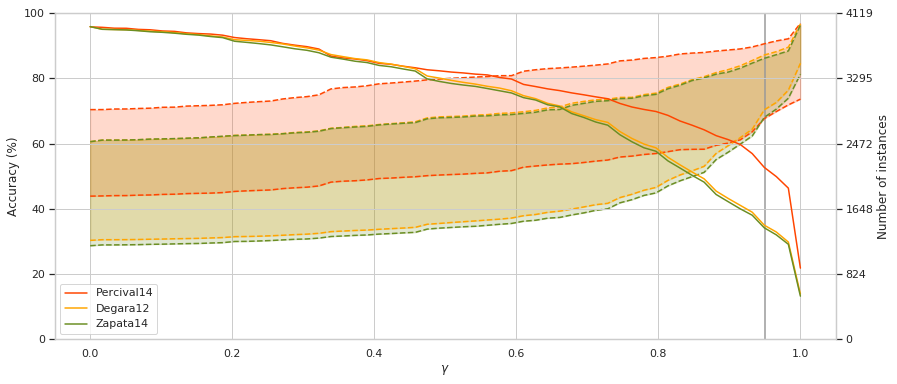

**Figure 2 - FSL4 **: Accuracy vs confidence measure for FSL4 dataset. Lower bounds of the 
    filled areas correspond to Accuracy 1e, while upper bounds correspond to Accuracy 2. Solid lines represent 
    the number of instances remaining in the dataset.
    


Confidence vs tempo estimation accuracy (Appleloops)
----------------------------------------------------



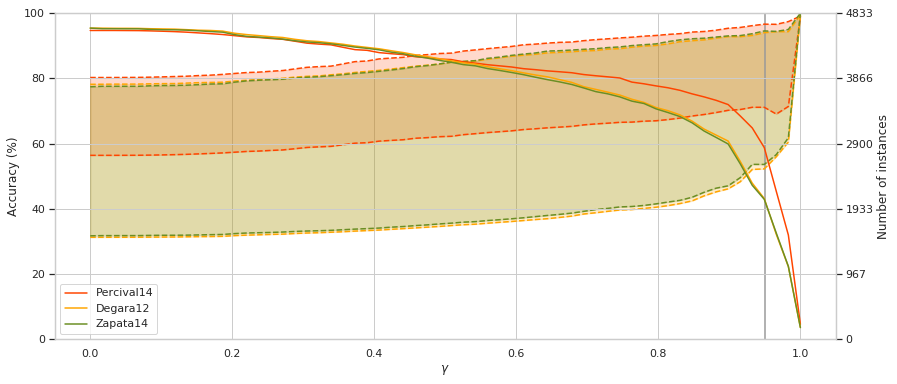

**Figure 2 - Appleloops **: Accuracy vs confidence measure for Appleloops dataset. Lower bounds of the 
    filled areas correspond to Accuracy 1e, while upper bounds correspond to Accuracy 2. Solid lines represent 
    the number of instances remaining in the dataset.
    


Confidence vs tempo estimation accuracy (Mixcraft)
--------------------------------------------------



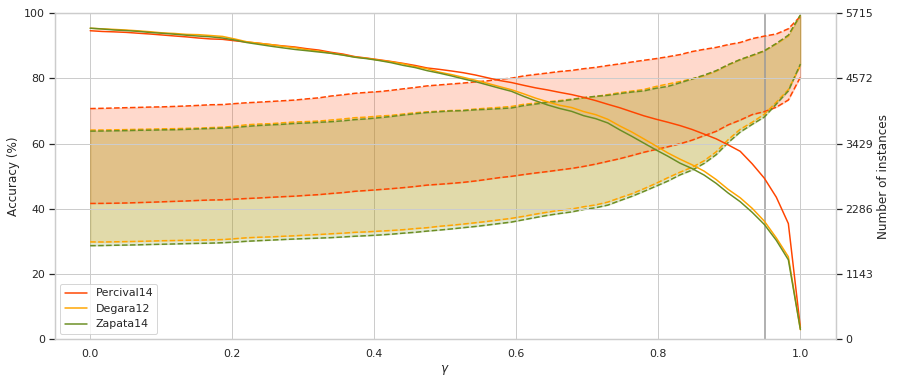

**Figure 2 - Mixcraft **: Accuracy vs confidence measure for Mixcraft dataset. Lower bounds of the 
    filled areas correspond to Accuracy 1e, while upper bounds correspond to Accuracy 2. Solid lines represent 
    the number of instances remaining in the dataset.
    

In [0]:
# Now do all the plotting

for dataset in datasets:
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))
    ax2 = ax1.twinx()

    for count, method in enumerate(['Percival14', 'Degara12', 'Zapata14']):
        accuracies_1e = list()
        accuracies_1 = list()
        accuracies_2 = list()
        counts = list()
        steps = np.linspace(0, 1, 60)
        for conf_min in steps:
            try:
                filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'confidence_ffont'), conf_min)]).data
                accuracies_1e.append(100 * basic_statistics(accuracy1e(filtered_data, method))['avg'])
                accuracies_1.append(100 * basic_statistics(accuracy1(filtered_data, method))['avg'])
                accuracies_2.append(100 * basic_statistics(accuracy2(filtered_data, method))['avg'])
                counts.append(len(filtered_data))
            except IndexError:
                raise Exception("Unable to compute basic statistics. Make sure that there is data available...")
                
        ax1.plot(steps, accuracies_1e, color=COLORS[count], ls="--")
        ax1.plot(steps, accuracies_2, color=COLORS[count], ls="--")
        ax1.fill_between(steps, accuracies_1e, accuracies_2, color=COLORS[count], alpha=0.2)
        ax2.plot(steps, counts, color=COLORS[count], label=method)

    print (title('Confidence vs tempo estimation accuracy (%s)' % dataset.short_name))
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('$\gamma$')
    ax2.set_ylabel('Number of instances')
    ax2.legend(loc=3)
    ax1.set_ylim((0, 100))
    ax1.set_yticks([float(ax1.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax2.set_ylim(0.0, ax2.get_ylim()[1])
    ax2.set_yticks([float(ax2.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax1.vlines(0.95, 0, 100, color='#999999')  # 95% confidence threshold
    plt.show()
    figure_caption = """**Figure 2 - %s **: Accuracy vs confidence measure for %s dataset. Lower bounds of the 
    filled areas correspond to Accuracy 1e, while upper bounds correspond to Accuracy 2. Solid lines represent 
    the number of instances remaining in the dataset.
    """ % (dataset.short_name, dataset.short_name)
    IPython.display.display(IPython.display.Markdown(figure_caption))

### Accuracy results for confidence > 95%

Filtering by the confidence measure, a potential user searching for loops in a dataset could define a minimum threshold to get more accurate results at the expense of getting less loops returned. 
For instance, if we set a hard confidence threshold of $\gamma=0.95$, we find that the accuracies for Percival14 method range, on average, from 67% (Accuracy 1e) to 92% (Accuracy 2) while preserving an average of 52% of the instances. 
Interestingly enough, we observe that when setting that hard threshold, reported RekBox accuracies outperform these of Percival14 in all datasets, with an average increase ranging from 2% for Accuracy 2 to 14% for Accuracy 1e (all statistically significant with $p \ll 0.01$). 

We attribute this to the fact that RekBox seems to have a built-in confidence measure thresholding step in which the algorithm outputs 0 BPM when the analysis does not meet certain confidence requirements. Therefore, once filtering the datasets by $\gamma$ (even with small values), all those instances whose BPM estimation is 0 BPM get discarded. Nevertheless, it is also important to note that filtering with the hard threshold, RekBox only preserves an average of 31% of the instances (lower than the 52% reported above by Percival14).

In [0]:
# Accuracy for for confidence threshold > 95%
conf_threshold = 0.95
table_header = ['Method'] + [dataset.short_name for dataset in datasets]
table_rows = list()
for method in methods_to_compare:
    table_row = list()
    table_row.append(method)
    for dataset in datasets:
        try:
            filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'confidence_ffont'), conf_threshold)]).data
            min_acc = 100 * basic_statistics(accuracy1e(filtered_data, method))['avg']
            max_acc = 100 * basic_statistics(accuracy2(filtered_data, method))['avg']
        except IndexError:
            print ('Unable to compute results for method %s and dataset %s' % (method, dataset.short_name))
            table_row.append('-')
            continue
        table_row.append('A=%.2f - %.2f%%, N=%.0f%%' % (min_acc, max_acc, 100 * float(len(filtered_data))/len(dataset.data)))
    table_rows.append(table_row)
print ('')
print_table(table_header, table_rows)


Method       FSL4                      Appleloops                Mixcraft                  
-------------------------------------------------------------------------------------------
Percival14   A=67.70 - 90.60%, N=55%   A=71.02 - 96.59%, N=61%   A=69.86 - 92.98%, N=51%   
Zapata14     A=68.09 - 86.21%, N=36%   A=53.53 - 94.49%, N=44%   A=68.30 - 88.55%, N=37%   
Degara12     A=70.42 - 87.22%, N=36%   A=52.05 - 94.01%, N=45%   A=69.11 - 88.51%, N=38%   
Bock15       A=46.66 - 86.32%, N=38%   A=56.82 - 91.25%, N=43%   A=52.33 - 87.59%, N=31%   


In [0]:
# Run pairwise statistical tests when filtering by 95% confidence
alpha = 0.01
conf_threshold = 0.95

def compute_mcnemar_test(method1_data, method2_data):
    stat, pvalue = mcnemar(method1_data, method2_data, exact=False)
    if pvalue < alpha:
        return "%.3g*" % pvalue
    return "%.3g" % pvalue

for count, dataset in enumerate(datasets):
    print ("")
    print (title('Statistical tests for dataset %s' % dataset.short_name))
    for accuracy_func in accuracy1e, accuracy1, accuracy2:
        print ('\nMeasure: %s' % accuracy_func.__name__)
        table_header = [' '] + [method for method in methods_to_compare]
        table_rows = list()
        for method_a in methods_to_compare:
            table_row = list()
            for method_b in methods_to_compare:
                if method_a != method_b:
                    filtered_data_a = dataset.filter_data([('analysis.%s.%s__>=' % (method_a, 'confidence_ffont'), conf_threshold)]).data
                    filtered_data_b = dataset.filter_data([('analysis.%s.%s__>=' % (method_a, 'confidence_ffont'), conf_threshold)]).data
                    result = compute_mcnemar_test(accuracy_func(filtered_data_a, method_a), accuracy_func(filtered_data_b, method_b))
                    table_row.append(result)
                else:
                    table_row.append('-')
            table_rows.append([method_a] + table_row)
        print_table(table_header, table_rows)



Statistical tests for dataset FSL4
----------------------------------


Measure: accuracy1e
             Percival14   Zapata14    Degara12    Bock15       
---------------------------------------------------------------
Percival14   -            1.9e-96*    1.27e-86*   2.87e-135*   
Zapata14     1.21e-09*    -           3.21e-15*   1.57e-92*    
Degara12     8.85e-13*    2.45e-29*   -           4.71e-96*    
Bock15       1.23e-14*    0.000184*   0.304       -            

Measure: accuracy1
             Percival14   Zapata14    Degara12    Bock15      
--------------------------------------------------------------
Percival14   -            4.56e-08*   1.11e-06*   3.12e-62*   
Zapata14     4.75e-13*    -           0.688       9.13e-55*   
Degara12     2.77e-17*    0.0339      -           2.88e-62*   
Bock15       2.39e-26*    1.49e-37*   3.55e-37*   -           

Measure: accuracy2
             Percival14   Zapata14    Degara12    Bock15      
-----------------------------------------

### Combined accuracy and confidence measure

Besides the overall accuracy measurements, we are also interested in observing how accuracy varies according to the confidence values that we estimate.
We can intuitively imagine that if we filter our datasets and only keep loops whose estimated confidence for the BPM prediction is above a certain confidence threshold, the overall accuracy results will increase. 
However, the higher we set the minimum confidence threshold, the smaller the size of filtered dataset will be.
Hence, we want to quantify the relation between the overall accuracy and the total number of music loops that remain in a dataset after filtering by minimum confidence.
To do that, given one of the aforementioned accuracy measures, we can define a minimum confidence threshold $\gamma$ and a function $A(\gamma)$ that represents overall BPM estimation accuracy when only evaluating loop instances whose estimated confidence value is above $\gamma$ for a given dataset and tempo estimation algorithm.
Similarly, we can define another function $N(\gamma)$ which returns the percentage of instances remaining in a dataset after filtering out those whose estimated confidence value (for a given tempo estimation method) is below $\gamma$. $A(\gamma)$ and $N(\gamma)$ can be understood as standard precision and recall curves, and therefore we can define a combined score measure $S(\gamma)$ doing the analogy with an f-measure computation:

$$ S(\gamma) = 2 \cdot \frac{A(\gamma) \cdot N(\gamma)}{A(\gamma) + N(\gamma)}.$$

An overall score for a given dataset, tempo estimation algorithm and accuracy measure can thus be given by taking the mean of $S(\gamma)$, $\bar S$. After computing $\bar S$ with our data, we again find that Percival14 obtains the best score in all datasets and for all accuracy measures (i.e.~for $A(\gamma)$ computed with Accuracy 1e, Accuracy 1 or Accuracy 2). This means that Percival14 offers the overall best balance between estimation accuracy and number of preserved instances in the dataset when filtering by a minimum confidence threshold.

In [0]:
# NOTE: To run this cell, confidence measures need to be computed first (see cells above)

def overall_method_score(accuracies, counts, dataset_size):
    """
    We normalize the counts to the dataset size so scores provided by datasets of different sizes are comparable.
    We also normalize accuracy values to go from 0 to 1 instead of from 0 to 100.
    Finally we divide the result by the number of bins of the histogram so that using histograms of different resolution
    should return similar results.
    """
    overall_score = 0.0
    length = len(counts)  # Should be the same as len(accuracies)
    for i in range(length):
        overall_score += 2 * ((float(counts[i])/dataset_size) * (float(accuracies[i])/100)) / ((float(counts[i])/dataset_size) + (float(accuracies[i])/100))
    return overall_score/length

for accuracy_func in accuracy1e, accuracy1, accuracy2:
    print (title('Combined score results for %s' % accuracy_func.__name__))
    table_header = ['Method'] + [dataset.short_name for dataset in datasets]
    table_rows = list()
    for method in methods_to_compare:
        table_row = list()
        table_row.append(method)
        for dataset in datasets:
            accuracies = list()
            counts = list()
            steps = np.linspace(0, 1, 60)
            for conf_min in steps:
                try:
                    filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, 'confidence_ffont'), conf_min)]).data
                    if filtered_data:
                        accuracies.append(100 * basic_statistics(accuracy_func(filtered_data, method))['avg'])
                    else:
                        accuracies.append(0.00000001)  # Use very small number to avoid division by 0, in any case counts will be 0 to so overall_score will be 0
                    counts.append(len(filtered_data))
                except IndexError:
                    raise Exception("Unable to compute basic statistics. Make sure that there is data available...")
            score = overall_method_score(accuracies, counts, dataset_size=len(dataset.data))
            table_row.append(score)
        table_rows.append(table_row)
    print_table(table_header, table_rows, sort_column=1, highlight_max=True)


Combined score results for accuracy1e
-------------------------------------

Method       FSL4   Appleloops   Mixcraft   
--------------------------------------------
Percival14   0.62   0.71         0.60       
Degara12     0.49   0.49         0.49       
Zapata14     0.47   0.50         0.47       
Bock15       0.39   0.51         0.36       

Combined score results for accuracy1
------------------------------------

Method       FSL4   Appleloops   Mixcraft   
--------------------------------------------
Percival14   0.70   0.80         0.68       
Degara12     0.66   0.76         0.65       
Zapata14     0.65   0.76         0.65       
Bock15       0.50   0.59         0.51       

Combined score results for accuracy2
------------------------------------

Method       FSL4   Appleloops   Mixcraft   
--------------------------------------------
Percival14   0.80   0.85         0.78       
Bock15       0.71   0.76         0.70       
Degara12     0.71   0.82         0.72       
Zapat

### Comparisson with confidence measure from Zapata14

Zapata et. al. [2] propose a confidence measure based on computing the mutual agreement between an ensemble of tempo estimation algorithms that take different sets of input features.
To make this confidence measure comparable to the one we propose, we normalise the confidence output of Zapata et. al. to take values form 0 to 1.
Similarly to Figure 2, we plot the estimation accuracy and the number of remaining instances as a function of a minimum confidence threshold $\gamma$ (Figure 3 in the cells below). 
We observe that Zapata's confidence measure allows to achieve accuracies which are around 15% higher than when using our confidence. However, the number of remaining instances in the dataset is drastically reduced, and accuracy values for $\gamma > 0.75$ become incosistent. 
Looking at the $\bar S$ score, we find that Zapata14 in combination with our confidence measure gets better results than when using the original measure, with an average $\bar S$ increase of 17%, 29% and 31% (for the three accuracy measures Accuracy 1e, Accuracy 1 and Accuracy 2 respectively). 
This indicates that the confidence measure we propose is able to better maximise accuracy and number of remaining instances.

[2] Jose R Zapata, Andre Holzapfel, Matthew EP Davied, Joao L Oliveira, and Fabien Gouyon. Assigning a 
Confidence Threshold on Automatic Beat Annotation in Large Datasets. In Proc. of the Int. Conf. on Music 
Information Retrieval (ISMIR), number Ismir, pages 157-162, 2012.


Confidence vs tempo estimation accuracy (FSL4)
----------------------------------------------



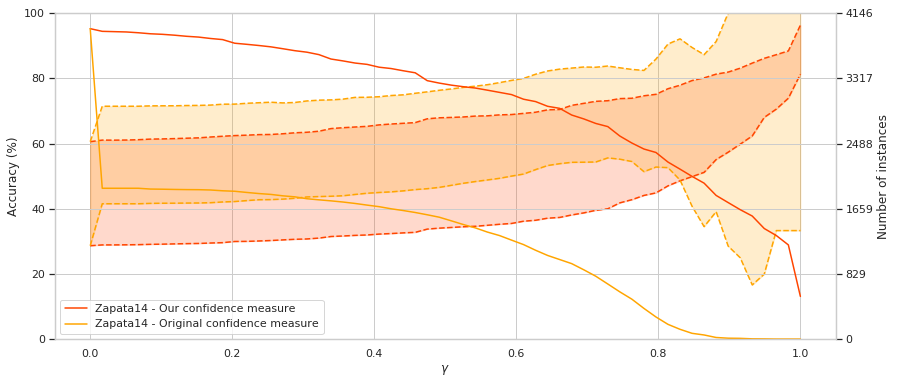

**Figure 3 - FSL4 **: Comparison of our proposed confidence measure with the confidence 
    measure proposed in [2] for FSL4 dataset and Zapata14 tempo estimation algorithm.
    


Confidence vs tempo estimation accuracy (Appleloops)
----------------------------------------------------



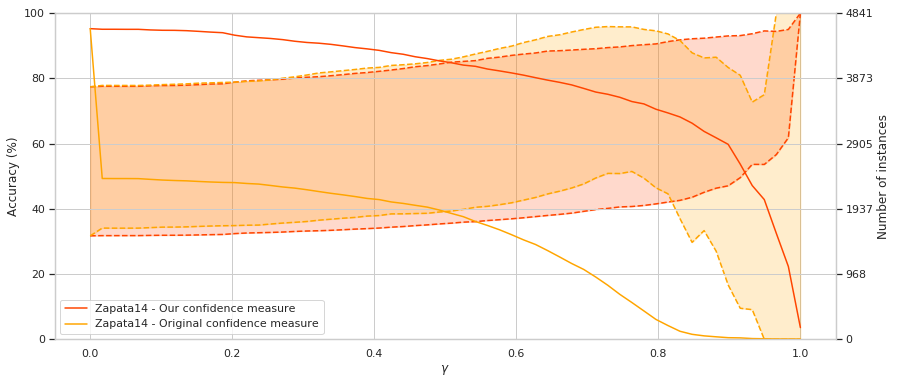

**Figure 3 - Appleloops **: Comparison of our proposed confidence measure with the confidence 
    measure proposed in [2] for Appleloops dataset and Zapata14 tempo estimation algorithm.
    


Confidence vs tempo estimation accuracy (Mixcraft)
--------------------------------------------------



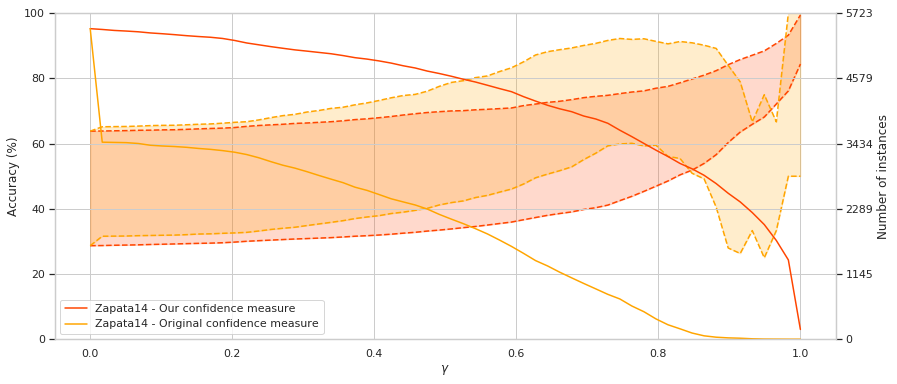

**Figure 3 - Mixcraft **: Comparison of our proposed confidence measure with the confidence 
    measure proposed in [2] for Mixcraft dataset and Zapata14 tempo estimation algorithm.
    

In [0]:
# Normalize confidence measure for Zapata14 so that numbers go from 0 to 1 and it is
# comparable with our confidence measure. We get the maximum and minimum value found in the dataset 
# and normalise the confidence to be in the [0, 1] range.
for dataset in datasets:    
    # Annotate all methods wirh confidence measures using the function above
    zapata_conf_values = dataset.get_data('analysis.Zapata14.confidence')
    if not zapata_conf_values:
        raise Exception('No information for Zapata14 method in dataset %s' % dataset.short_name)
    max_value = max(zapata_conf_values)
    min_value = min(zapata_conf_values)
    for key, item in dataset.data.items():
        try:
            normalised_value = float(item['analysis']['Zapata14']['confidence'] - min_value)/(max_value - min_value)
            item['analysis']['Zapata14']['confidence_zapata'] = normalised_value
        except KeyError:
            continue
            
CONFIDENCE_MEASURE_NAMES = {
    'confidence_ffont': 'Our confidence measure',
    'confidence_zapata': 'Original confidence measure'
}
        
for dataset in datasets:
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))
    ax2 = ax1.twinx()
    methods_and_conf_to_compare = [('Zapata14', 'confidence_ffont'), 
                                   ('Zapata14', 'confidence_zapata')]
   
    for count, (method, conf_method) in enumerate(methods_and_conf_to_compare):
        accuracies_1e = list()
        accuracies_1 = list()
        accuracies_2 = list()
        counts = list()
        steps = np.linspace(0, 1, 60)
        for conf_min in steps:
            try:
                filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, conf_method), conf_min)]).data
                accuracies_1e.append(100 * basic_statistics(accuracy1e(filtered_data, method))['avg'])
                accuracies_1.append(100 * basic_statistics(accuracy1(filtered_data, method))['avg'])
                accuracies_2.append(100 * basic_statistics(accuracy2(filtered_data, method))['avg'])
                counts.append(len(filtered_data))
            except IndexError:
                raise Exception("Unable to compute basic statistics. Make sure that there is data available...")
        
        ax1.plot(steps, accuracies_1e, color=COLORS[count], ls="--")
        ax1.plot(steps, accuracies_2, color=COLORS[count], ls="--")
        ax1.fill_between(steps, accuracies_1e, accuracies_2, 
                         color=COLORS[count], alpha=0.2)
        ax2.plot(steps, counts, color=COLORS[count], label="%s - %s" % (method, CONFIDENCE_MEASURE_NAMES[conf_method]))

    print (title('Confidence vs tempo estimation accuracy (%s)' % dataset.short_name))
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('$\gamma$')
    ax2.set_ylabel('Number of instances')
    ax2.legend(loc=3)
    ax1.set_ylim((0, 100))
    ax1.set_yticks([float(ax1.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    ax2.set_ylim(0.0, ax2.get_ylim()[1])
    ax2.set_yticks([float(ax2.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    plt.show()
    figure_caption = """**Figure 3 - %s **: Comparison of our proposed confidence measure with the confidence 
    measure proposed in [2] for %s dataset and Zapata14 tempo estimation algorithm.
    """ % (dataset.short_name, dataset.short_name)
    IPython.display.display(IPython.display.Markdown(figure_caption))

In [0]:
# Compute combined scores for Zapata14 method using confidence_ffont or confidence_zapata
# NOTE: to run this cell 'overall_method_score' must have been defined (see cells above)

methods_and_conf_to_compare = [('Zapata14', 'confidence_ffont'), 
                               ('Zapata14', 'confidence_zapata')]
for accuracy_func in accuracy1e, accuracy1, accuracy2:
    print (title('Combined score results for %s' % accuracy_func.__name__))
    table_header = ['Method - Conf method'] + [dataset.short_name for dataset in datasets]
    table_rows = list()
    for method, conf_method in methods_and_conf_to_compare:
        table_row = list()
        table_row.append('%s - %s' % (method, conf_method))
        for dataset in datasets:
            accuracies = list()
            counts = list()
            steps = np.linspace(0, 1, 60)
            for conf_min in steps:
                try:
                    filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, conf_method), conf_min)]).data
                    if filtered_data:
                        accuracies.append(100 * basic_statistics(accuracy_func(filtered_data, method))['avg'])
                    else:
                        accuracies.append(0.00000001)  # Use very small number to avoid division by 0, in any case counts will be 0 to so overall_score will be 0
                    accuracies.append(100 * basic_statistics(accuracy_func(filtered_data, method))['avg'])
                    counts.append(len(filtered_data))
                except IndexError:
                    raise Exception("Unable to compute basic statistics. Make sure that there is data available...")
            score = overall_method_score(accuracies, counts, dataset_size=len(dataset.data))
            table_row.append(score)
        table_rows.append(table_row)
    print_table(table_header, table_rows, sort_column=1, highlight_max=True)


Combined score results for accuracy1e
-------------------------------------

Method - Conf method           FSL4   Appleloops   Mixcraft   
--------------------------------------------------------------
Zapata14 - confidence_ffont    0.43   0.46         0.42       
Zapata14 - confidence_zapata   0.31   0.29         0.29       

Combined score results for accuracy1
------------------------------------

Method - Conf method           FSL4   Appleloops   Mixcraft   
--------------------------------------------------------------
Zapata14 - confidence_ffont    0.62   0.74         0.63       
Zapata14 - confidence_zapata   0.38   0.38         0.37       

Combined score results for accuracy2
------------------------------------

Method - Conf method           FSL4   Appleloops   Mixcraft   
--------------------------------------------------------------
Zapata14 - confidence_ffont    0.68   0.80         0.69       
Zapata14 - confidence_zapata   0.39   0.42         0.41       
